## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
%matplotlib inline

# We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Read the dataset
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Number of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# Number of unique users
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
# Percentage of users converted
df.converted.mean() * 100

11.965919355605511

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# Number of times where "new_page" and "treatment" they don't match
df.query('group != "treatment" and landing_page == "new_page"').shape[0] + \
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
# Check the information for each column to see if there are missing values
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Create a new dataframe without the data that doesn't match
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')
df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

In [10]:
# Show the header of the dataframe 'df2'
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. How many unique **user_id**s are in **df2**?

In [11]:
# Number of unique users
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# Show the user_id that is duplicated
df2.loc[df2.user_id.duplicated(), 'user_id'].values[0]

773192

c. What is the row information for the repeat **user_id**? 

In [13]:
# Rows with the information of the repeated user_id
duplicated_user_id = df2.loc[df2.user_id.duplicated(), 'user_id'].values[0]
df2[df2.user_id == duplicated_user_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
# Drop the duplicated rows
df2 = df2.drop_duplicates(['user_id'], keep='first')

# Show nº of rows
df2.shape[0]

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
# Probability of an individual converting
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
# Probability of an individual converting in the group "control"
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
# Probability of an individual converting in the group "treatment"
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
# Probability of an individual to receive the new page
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [19]:
# Difference between the two converted tyes
(df2.query('group == "control"').converted.mean() - df2.query('group == "treatment"').converted.mean()) * 100

0.15782389853555567

**As we can see, the difference between each group is 0.15% so it's almost the same. In this case, even that the sample size it's really big and the small difference in big datasets they are really important in this case we need to consider other factors to really conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$$ H_0: p_{old} - p_{new} \geq 0 $$
$$ H_1: p_{old} - p_{new} < 0 $$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
# Converted mean of P_new
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
# Converted mean of P_old
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
# Number of individuals in the treatment group
n_new = df2.query('group == "treatment"').user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
# Number of individuals in the control group
n_old = df2.query('group == "control"').user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# Simulation of n_new transactions with a probability of p_new for 0 and (1- p_new) for 1
new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new])
new_page_converted.mean()

0.88092354277062834

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# Simulation of n_old transactions with a probability of p_old for 0 and (1 - p_old) for 1
old_page_converted = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old])
old_page_converted.mean()

0.8792901689221746

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
# Difference of the two simulations
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.0016333738484537452

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
# Create a sampling distribution of the difference with bootstrapping
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
# Transform to a NumPy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

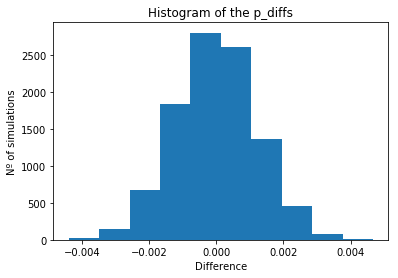

In [28]:
# Histogram of the difference from the sampling distribution
plt.hist(p_diffs);
plt.title('Histogram of the p_diffs');
plt.xlabel('Difference');
plt.ylabel('Nº of simulations');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
# Calculate the actual difference in the original dataset
a_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

# Calculate the proportion of p_diffs that are greater than a_diffs
(p_diffs > a_diffs).mean()

0.90049999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The calculation in the previous question was the p-value that tells to us the probability of getting our statistic or a more extreme value if the null is true.
As we can see, the value is 0.9 and this means that we can't reject the $H_0$. This means that the old page is better or equal than the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0] 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [32]:
# Calculate the significance of z_score
norm.cdf(z_score)

0.90505831275902449

In [33]:
# Calculate the critical value at 95% CI
norm.ppf(1-0.05)

1.6448536269514722

**As we can see the $z_{score}$ that we found is less than the critical value at 95% CI, so it means that we fail to reject $H_0$. This also agrees with the calculations we did in the part $j$ and $k$.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**In this case due to the output of the dependent variable is binary, it is the case of a Logisitic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
# Create a copy of df2
df3 = df2

# Add the intercept column
df3['intercept'] = 1

# Create dummies variables
df3[['control','ab_page']] = pd.get_dummies(df2.group)

# Drop column 'control'
df3.drop('control', axis = 1, inplace = True)

# Show the head
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
# Create a logistic regression using statsmodels
logit  = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
# Show the summary of the model
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 15:29 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**As we can see in the table the p-value associated with $ab_page$ is 0.1899.
The reason why the p-value it's different is because in this case the $H_0$ and $H_1$ is different than the Part II.
In this case, because it is a two-sided test, the hypotheses are:
$$ H_0: p_{old} - p_{new} = 0$$
$$ H_1: p_{old} - p_{new} \neq 0$$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The adventages of adding more factors in the model are:**
- Using more parameters can help the model to have better accuracy, like for example to have if the day it is a public holiday or not, if it was black friday and in the e-commerce it was an offer, or it was christams can help to understant better why there are more converteds some days of the year compared to others. Another thing that could be useful to have is the age, birth date, city, etc.

**The disadvantages of adding more factors in the model are:**
- With too many factors the model can produce inaccurate results due to the multicollinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# Read the new dataset
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# Merge the original dataset with the countries data
df4 = countries.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df4.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [39]:
# Check the number of different values in the column 'country'
df4.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Now I will create the dummies variables of the column 'country'. I will choose 'CA' as the baseline.

In [40]:
# Create dummy variables for 'country'
df4[['UK', 'US']] = pd.get_dummies(df4['country'])[['UK','US']]
df4.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [41]:
# Create a logistic regression using statsmodels
logit = sm.Logit(df4['converted'], df4[['intercept', 'UK', 'US']])
results = logit.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 15:29 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**As we can see, the p-values for each country is higher than 0.05, so we can say that there are not statistical evidence that the country significantly effects on the conversion for the users.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
# Create a logistic regression using statsmodels
logit = sm.Logit(df4['converted'], df4[['intercept', 'UK', 'US', 'ab_page']])
results = logit.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-20 15:29 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

**Looking at the table above, we can see that even with the page data the p-value it is still not statistical significance in any case due to is higher than 0.05 in all of them.**

In [43]:
# Create HTML file
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0